<h1>Hybrid Movie Recommender System for Mobile Devices</h1>

<h2>Module 1: Data Pre-Processing</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle
from matplotlib import pyplot
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
#!pip install surprise
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from collections import defaultdict


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
moviesdata= pd.read_csv('movie.csv')
tagsdata= pd.read_csv('tag.csv')
ratingsdata= pd.read_csv('rating.csv')

In [4]:

ratingsdata=ratingsdata.sample(n=5000000)
moviesdata

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [5]:
moviesdata['genres']=moviesdata['genres'].str.replace('|',' ')

In [6]:
len(moviesdata.movieId.unique())

27278

In [7]:
ratingsdata

,userId,movieId,rating,timestamp
12895665,89067,30820,5.0,2008-08-22 16:22:34
7038707,48536,2012,5.0,2001-09-02 13:45:41
5804694,39967,1967,3.0,2003-07-14 15:58:01
14522086,100358,1297,3.0,2012-10-23 02:44:46
16067277,111173,592,2.0,1996-07-19 16:01:04
...,...,...,...,...
13899899,96011,1777,3.0,2007-03-24 21:55:42
238455,1644,30749,3.5,2014-12-18 20:30:36
9078293,62800,1288,4.0,2008-08-25 15:12:32
2506298,16959,589,4.5,2005-07-20 01:13:09


In [8]:
#The rating data can be shrinked to consider only the users that have rated more than 30 movies.
filtered_ratings=ratingsdata.groupby('userId').filter(lambda x:len(x)>= 30)
#This allows the data to retain most of the movies while reducing the amount of users.
mlr = filtered_ratings.movieId.unique().tolist()
titlesremaining = len(filtered_ratings.movieId.unique())/len(moviesdata.movieId.unique()) * 100


In [9]:
# we take only the unique movie titles that are also present in the new filtered data.
moviesdata=moviesdata[moviesdata.movieId.isin(mlr)]

In [10]:
moviesdata.head(10)
# so now we have the genres without the | seperators

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action Crime Thriller
6,7,Sabrina (1995),Comedy Romance
7,8,Tom and Huck (1995),Adventure Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action Adventure Thriller


In [11]:
Mapit = dict(zip(moviesdata.title.tolist(),moviesdata.movieId.tolist()))
#create a dictionary for movie titles and id for fast lookup

In [12]:
#getting rid of timestamp column as it is not needed
tagsdata.head
tagsdata.drop(['timestamp'],1,inplace=True)
filtered_ratings.drop(['timestamp'],1, inplace=True)

In [13]:
#merging the dataframes to get consolidated dataset
mxmat=pd.merge(moviesdata,tagsdata,on='movieId',how='left')
mxmat.head(10)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Pixar animation
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,TÃ©a Leoni does not star in this movie
5,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,2299.0,Pixar
6,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3596.0,animation
7,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3596.0,family
8,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3596.0,Tom Hanks
9,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,6233.0,Pixar


In [14]:
mxmat.fillna("",inplace=True)
mxmat = pd.DataFrame(mxmat.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
finmat = pd.merge(moviesdata, mxmat, on='movieId', how='left')
finmat ['metdat'] = finmat[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
finmat[['movieId','title','metdat']].head(10)
# combining tags and genres to generte data for content based recommendation later

,movieId,title,metdat
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...
3,4,Waiting to Exhale (1995),chick flick revenge characters chick flick cha...
4,5,Father of the Bride Part II (1995),Diane Keaton family sequel Steve Martin weddin...
5,6,Heat (1995),realistic action Al Pacino Michael Mann Robert...
6,7,Sabrina (1995),Greg Kinnear romance remadeAs:Sabrina(1995) re...
7,8,Tom and Huck (1995),adapted from:book author:Mark Twain Library Sy...
8,9,Sudden Death (1995),action jean-claude van damme Peter Hyams Jean-...
9,10,GoldenEye (1995),007 (series) assassin killer as protagonist mu...


In [15]:
print('Percentage of titles remaining in dataset out of original:')
print(titlesremaining)
termfrinvfr=TfidfVectorizer(stop_words='english')
termfrinvfr_matrix=termfrinvfr.fit_transform(finmat['metdat'])
termfrinvfr_df = pd.DataFrame(termfrinvfr_matrix.toarray(), index=finmat.index.tolist())
# using stopwords from sklearn library to generate tf-idf matrix
#print(termfrinvfr_df.shape)

Percentage of titles remaining in dataset out of original:
77.05843536916196


In [16]:
singularVD = TruncatedSVD(n_components=200)
intermatgen = singularVD.fit_transform(termfrinvfr_matrix)
n = 200 
intermatgen_1_df = pd.DataFrame(intermatgen[:,0:n], index=finmat.title.tolist())
intermatgen.shape

(21020, 200)

In [17]:
filtered_ratings.head(10)

,userId,movieId,rating
5804694,39967,1967,3.0
14522086,100358,1297,3.0
14948992,103244,1863,3.0
2301447,15612,3946,2.0
3109473,21185,1200,4.0
4938095,33985,2085,3.5
17477798,120890,3392,2.0
4851574,33349,1353,3.5
1962081,13296,4881,2.5
3946419,26888,44197,3.5


In [18]:
filtered_ratings1 = pd.merge(moviesdata[['movieId']], filtered_ratings, on="movieId", how="right")

In [19]:
filtered_ratings1.head(10)
filtered_ratings2=pd.pivot(filtered_ratings1,index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [20]:
filtered_ratings2.head(10)

userId,1,3,7,11,14,18,21,22,24,29,...,138467,138472,138474,138475,138477,138483,138484,138486,138490,138493
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h1>Module 2: Hybrid Recommendations</h1>

In [21]:
len(filtered_ratings.movieId.unique())

21020

In [22]:
singularVD = TruncatedSVD(n_components=200)
intermatgensec = singularVD.fit_transform(filtered_ratings2)
intermatgensecdata = pd.DataFrame(intermatgensec, index=finmat.title.tolist())

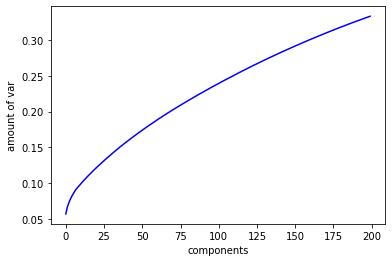

In [23]:
explotter = singularVD.explained_variance_ratio_.cumsum()
plt.plot(explotter,'-', ms = 16, color='blue')
plt.xlabel('components', fontsize= 10)
plt.ylabel('amount of var', fontsize=10)        
plt.show()

In [24]:
simmovie_1= np.array(intermatgen_1_df.loc['Toy Story (1995)']).reshape(1, -1)
simmovie_2 = np.array(intermatgensecdata.loc['Toy Story (1995)']).reshape(1, -1)
conscore = cosine_similarity(intermatgen_1_df, simmovie_1).reshape(-1)
collabscore = cosine_similarity(intermatgensecdata, simmovie_2).reshape(-1)
hybridsim = ((conscore + collabscore)/2.0)
simdic = {'content': conscore , 'collaborative': collabscore, 'hybrid': hybridsim} 
simdf = pd.DataFrame(simdic, index = intermatgen_1_df.index )
simdf.sort_values('content', ascending=False, inplace=True)
#simdf[1:].head(10)

In [25]:
simdf[0:].content.head(10)

Toy Story (1995)              1.000000
Toy Story 2 (1999)            0.963945
Bug's Life, A (1998)          0.912933
Ratatouille (2007)            0.902560
Monsters, Inc. (2001)         0.891622
Ice Age (2002)                0.881773
Finding Nemo (2003)           0.876598
Toy Story 3 (2010)            0.871719
Monsters University (2013)    0.804264
Incredibles, The (2004)       0.803751
Name: content, dtype: float64

In [26]:
simdf[0:].collaborative.head(10)

Toy Story (1995)              1.000000
Toy Story 2 (1999)            0.177574
Bug's Life, A (1998)          0.177603
Ratatouille (2007)            0.254035
Monsters, Inc. (2001)         0.160794
Ice Age (2002)                0.288134
Finding Nemo (2003)           0.152714
Toy Story 3 (2010)            0.241810
Monsters University (2013)    0.146427
Incredibles, The (2004)       0.146596
Name: collaborative, dtype: float64

In [27]:
simdf[0:].hybrid.head(10)

Toy Story (1995)              1.000000
Toy Story 2 (1999)            0.570759
Bug's Life, A (1998)          0.545268
Ratatouille (2007)            0.578298
Monsters, Inc. (2001)         0.526208
Ice Age (2002)                0.584953
Finding Nemo (2003)           0.514656
Toy Story 3 (2010)            0.556764
Monsters University (2013)    0.475346
Incredibles, The (2004)       0.475174
Name: hybrid, dtype: float64

<h1>Final Module:</h1>

In [28]:
def showprecrec(predrat, k=10, threshold=3.5):
    uet = defaultdict(list)
    for uid, _, true_r, est, _ in predrat:
        uet[uid].append((est, true_r))
    precc = dict()
    recc = dict()
    for uid, urats in uet.items():
        urats.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in urats)
        n_rec_k = sum((est >= threshold) for (est, _) in urats[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in urats[:k])
        precc[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recc[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precc, recc

In [29]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(filtered_ratings[['userId','movieId','rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD()
algo.fit(trainset)
predrat = algo.test(testset)
print(accuracy.rmse(predrat, verbose=True)) # rmse 
# can calculate better accuracy[precsion and recall bhi calculate] by using K fold shaayd but then hit ratio 83 tha  idk :(((
# time will inccrrease to about 10 min but :)v
#kf = KFold(n_splits=5)
'''for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predrat = algo.test(testset)
    precc, recc = showprecrec(predrat, k=5, threshold=4)
    print('precision and recall at k')
    print(sum(prec for prec in precc.values()) / len(precc))
    print(sum(rec for rec in recc.values()) / len(recc))
    print(accuracy.rmse(predrat, verbose=True))'''
    

RMSE: 0.8415
0.8414535824041421


"for trainset, testset in kf.split(data):\n    algo.fit(trainset)\n    predrat = algo.test(testset)\n    precc, recc = showprecrec(predrat, k=5, threshold=4)\n    print('precision and recall at k')\n    print(sum(prec for prec in precc.values()) / len(precc))\n    print(sum(rec for rec in recc.values()) / len(recc))\n    print(accuracy.rmse(predrat, verbose=True))"

In [30]:
def recommovie(ui):
    if ui in filtered_ratings.userId.unique():
        listforuser = filtered_ratings[filtered_ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapit.items() if not v in listforuser}        
        predlus = []
        for i, j in d.items():     
            predic = algo.predict(ui, j)
            predlus.append((i, predic[3])) 
        predf = pd.DataFrame(predlus, columns = ['movies', 'ratings'])
        predf.sort_values('ratings', ascending=False, inplace=True)  
        predf.set_index('movies', inplace=True) 
        return predf.head(10)        
    else:
        print("Does not exist")
        return None

In [31]:
recommovie(21496)

,ratings
movies,
"Clockwork Orange, A (1971)",4.920828
This Is Spinal Tap (1984),4.849593
Eternal Sunshine of the Spotless Mind (2004),4.812872
Apocalypse Now (1979),4.800879
Adaptation (2002),4.790083
"Streetcar Named Desire, A (1951)",4.785025
Casablanca (1942),4.779612
2001: A Space Odyssey (1968),4.775551
Chinatown (1974),4.761315


In [32]:
uusers = filtered_ratings.userId.unique()

In [33]:
uusers

array([ 39967, 100358, 103244, ..., 114607,  76727,  82441], dtype=int64)

In [34]:
uusers = uusers[0:50]

In [35]:
uusers
listofusers = uusers.tolist()

In [36]:
from tkinter import *
from tkinter.ttk import Combobox
class mywin:
    def __init__(self, win):
        self.lb1 = Label(win, text='Select the user to recommend for: ')
        #self.lb2 = Label(win, text='RECOMMENDER SYSTEM DEMO')
        data=listofusers
        self.cb=Combobox(window, values=data)
        self.lb=Listbox(window, height=10,width = 70, selectmode='multiple')
        self.cb.place(x=5, y=100)
        self.btn1 = Button(win, text='Add')
        self.b1=Button(win, text='Recommend', command=self.recom)
        self.lb1.place(x=0, y=50)
        #self.lb2.place(x=0,y=10)
        self.b1.place(x=200, y=95)
        self.lb.place(x=300, y=95)
        self.T = Text(win, height=1, width=30,font='Helvetica 12 bold')
        self.T.pack()
        self.T.insert(END, "HYBRID RECOMMENDER SYSTEM")
    def recom(self):
        self.lb.delete(0,END)
        uid = self.cb.get()
        uid = int(uid)
        #print(type(uid))
        op = recommovie(uid)
        finalmovies = op.index.tolist()
        for n in finalmovies:
            self.lb.insert(END,n)
        #print(finalmovies)
        
window=Tk()
mywin=mywin(window)
window.title('Hybrid Recommender System')
window.geometry("800x400+10+10")
window['background']='#003366'
window.mainloop()

In [37]:
listofusers

[39967,
 100358,
 103244,
 15612,
 21185,
 33985,
 120890,
 33349,
 13296,
 26888,
 38552,
 106097,
 64430,
 63247,
 3236,
 124181,
 14856,
 102587,
 41859,
 8805,
 16452,
 56394,
 128854,
 108097,
 120105,
 93808,
 94612,
 104129,
 26926,
 92302,
 554,
 6966,
 62632,
 46470,
 9784,
 66562,
 55261,
 31715,
 42077,
 35109,
 71992,
 85034,
 134627,
 84700,
 25477,
 78781,
 112269,
 119517,
 108123,
 100778]